In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import zipfile
import pathlib

from PIL import Image

from sklearn.model_selection import train_test_split
import shutil

import tensorflow as tf
from tensorflow import keras
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,  models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3

SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
import random
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

ModuleNotFoundError: No module named 'cv2'

# Read Dataset

In [129]:
zip_ref = zipfile.ZipFile("Dataset 2A.zip", "r")
zip_ref.extractall("Dataset 2A/")
zip_ref.close()

In [130]:
for dirpath, dirnames, filenames in os.walk("Dataset 2A"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'Dataset 2A'.
There are 4 directories and 0 images in 'Dataset 2A\Testing'.
There are 0 directories and 300 images in 'Dataset 2A\Testing\glioma'.
There are 0 directories and 306 images in 'Dataset 2A\Testing\meningioma'.
There are 0 directories and 405 images in 'Dataset 2A\Testing\notumor'.
There are 0 directories and 300 images in 'Dataset 2A\Testing\pituitary'.
There are 4 directories and 0 images in 'Dataset 2A\Training'.
There are 0 directories and 1321 images in 'Dataset 2A\Training\glioma'.
There are 0 directories and 1339 images in 'Dataset 2A\Training\meningioma'.
There are 0 directories and 1595 images in 'Dataset 2A\Training\notumor'.
There are 0 directories and 1457 images in 'Dataset 2A\Training\pituitary'.


In [131]:
data_dir = pathlib.Path("Dataset 2A/Training/") 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)

['glioma' 'meningioma' 'notumor' 'pituitary']


# EDA

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

Image shape: (512, 512)


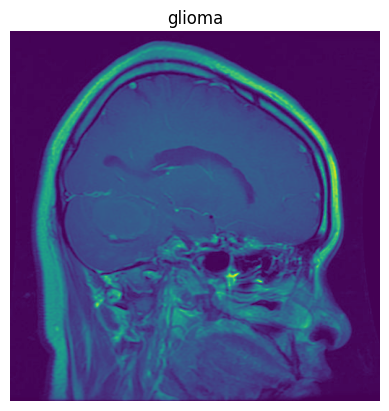

In [133]:
img = view_random_image(target_dir="Dataset 2A/Training/",
                        target_class="glioma")

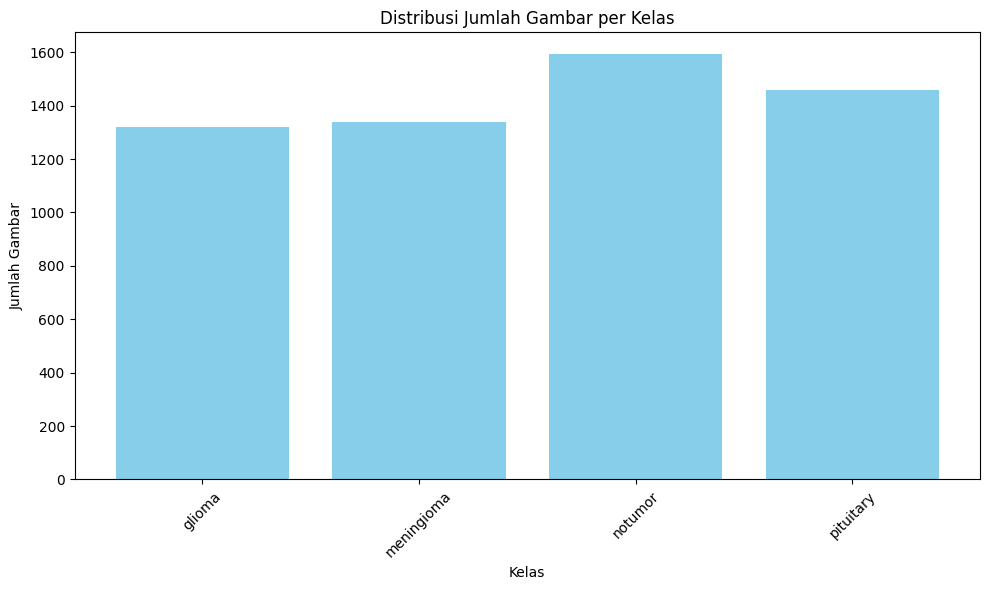

In [134]:
class_counts = {class_name: len(list((data_dir / class_name).glob('*'))) for class_name in class_names}

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


From the graph above, we can see that the data is spread evenly with each categories with over 1200 each.

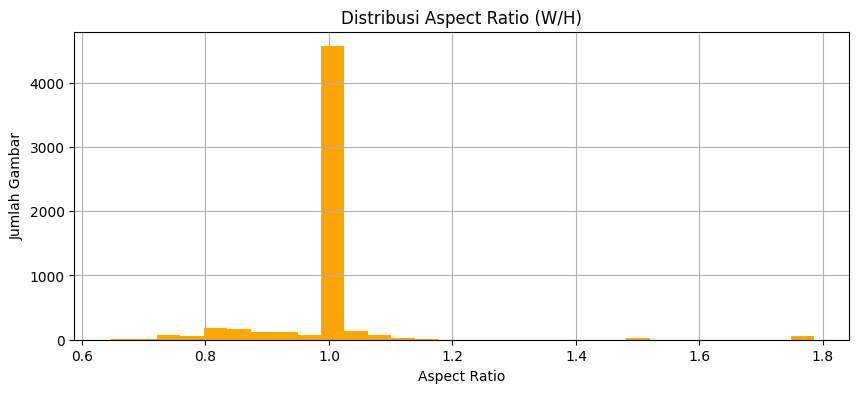

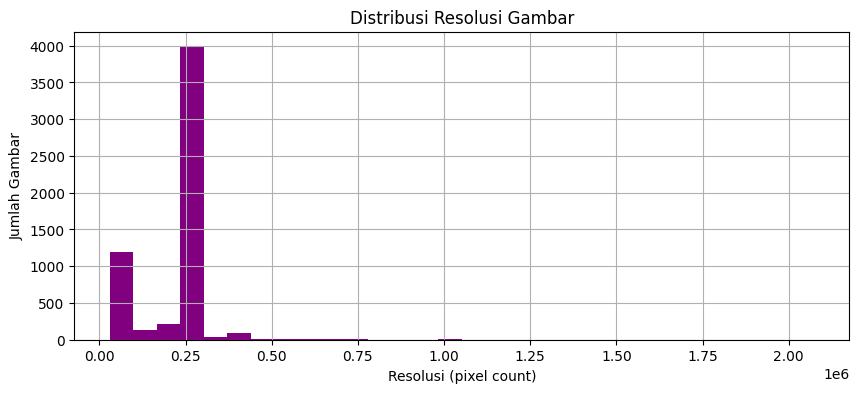

In [ ]:
aspect_ratios = []
resolutions = []

for class_name in class_names:
    class_path = data_dir / class_name
    for img_path in class_path.glob("*"):
        with Image.open(img_path) as img:
            width, height = img.size
            aspect_ratios.append(width / height)
            resolutions.append(width * height)

plt.figure(figsize=(10, 4))
plt.hist(aspect_ratios, bins=30, color='orange')
plt.title("Distribusi Aspect Ratio (W/H)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Jumlah Gambar")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(resolutions, bins=30, color='purple')
plt.title("Distribusi Resolusi Gambar")
plt.xlabel("Resolusi (pixel count)")
plt.ylabel("Jumlah Gambar")
plt.grid(True)
plt.show()


Aspect Raio : Mayority of the picture in the data has aspect ratio of 1 which means that almost all of the picture is square sized. This is good because the picture can be resized without the need of cropping or extreme padding. This also makes the model to become more stable while learning. 

Picture Resolution : Most of the picture has resolution in the 0.25 million pixel range or roughly 200.000 pixel. Means that mostly sized 400x500 or 300x600 pixel. The distribution is not even, but not centralized on one cluster which makes this dataset homogen in terms of resolution and really good for training

In [183]:
image_paths_by_category = {
    class_name: list((data_dir / class_name).glob('*'))
    for class_name in class_names
}

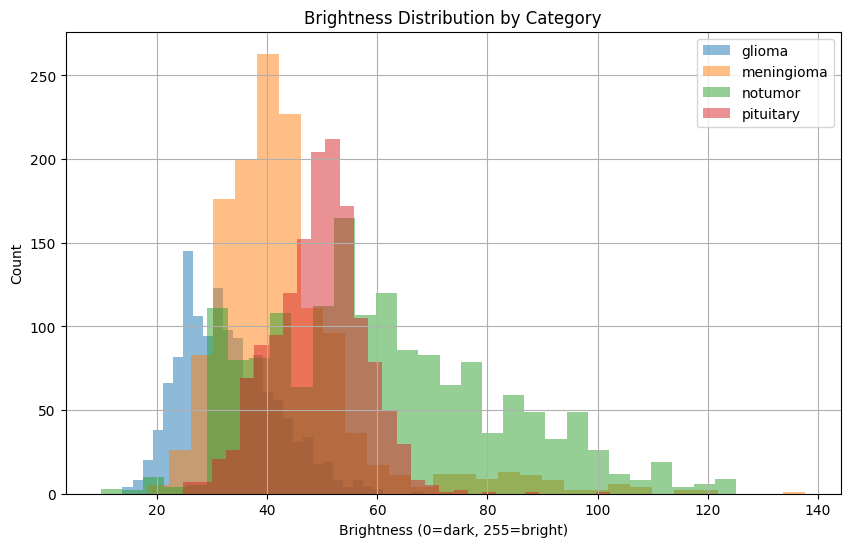

In [184]:
def analyze_brightness_combined(image_paths_by_category):
    plt.figure(figsize=(10, 6))

    for category, paths in image_paths_by_category.items():
        brightness_values = []
        for img_path in paths:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            brightness = np.array(img).mean()
            brightness_values.append(brightness)

        plt.hist(brightness_values, bins=30, alpha=0.5, label=category)

    plt.title('Brightness Distribution by Category')
    plt.xlabel('Brightness (0=dark, 255=bright)')
    plt.ylabel('Count')
    plt.grid(True)
    plt.legend()
    plt.show()
analyze_brightness_combined(image_paths_by_category)

From this graph, we can see that glioma has a darker picture, meningioma and pituitary has a brighter color while notumor is spread evenly. This implify that brightness may contribute to model in classifying types of tumor. But if brightness is too dominant then the model may overfit to brightness.

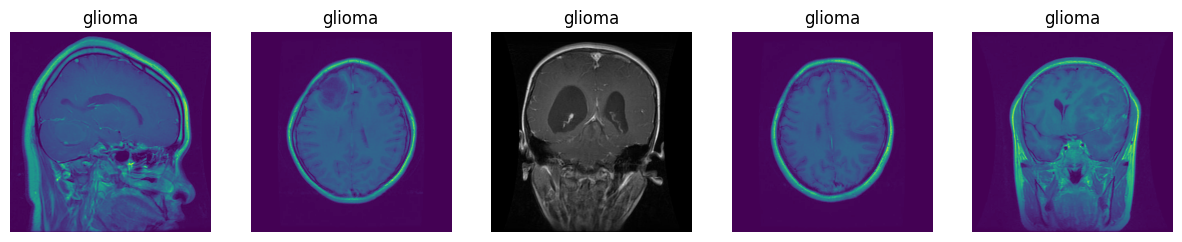

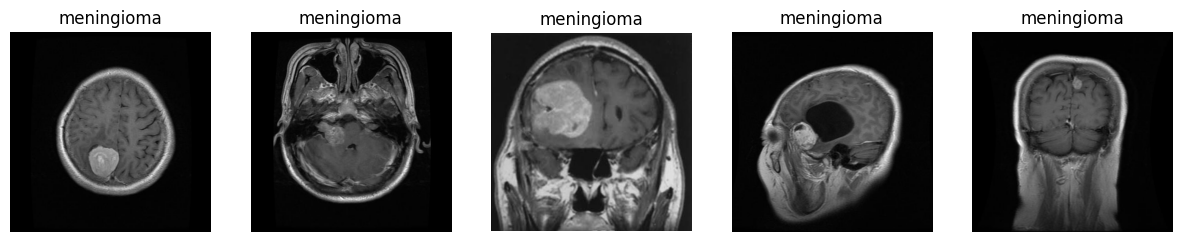

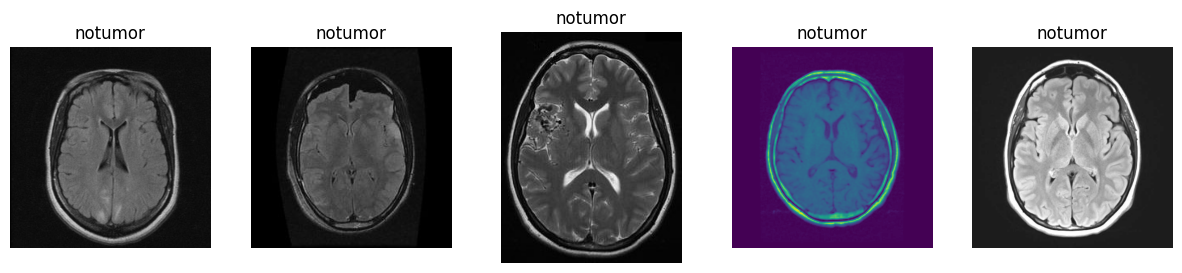

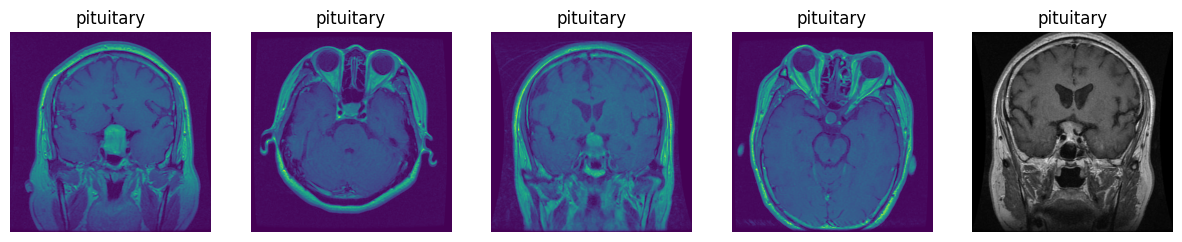

In [140]:
def show_random_images(class_name, n=5):
    img_paths = list((data_dir / class_name).glob('*'))
    random_imgs = random.sample(img_paths, min(n, len(img_paths)))

    plt.figure(figsize=(15, 3))
    for i, img_path in enumerate(random_imgs):
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Tampilkan contoh dari 3 kelas pertama
for class_name in class_names[:4]:
    show_random_images(class_name)


# Split Data into Train, Val, Test

In [141]:
import pathlib
import shutil
from sklearn.model_selection import train_test_split

base_dir = pathlib.Path("Dataset 2A")
train_source_dir = base_dir / "Training"
test_source_dir = base_dir / "Testing"

split_base_dir = base_dir / "split"
split_train_dir = split_base_dir / "training"
split_val_dir = split_base_dir / "validation"
split_test_dir = split_base_dir / "testing"

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

for split_dir in [split_train_dir, split_val_dir, split_test_dir]:
    for class_name in class_names:
        (split_dir / class_name).mkdir(parents=True, exist_ok=True)

def get_image_paths(class_folder):
    image_paths = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        image_paths.extend((class_folder).glob(ext))
    return image_paths

for class_name in class_names:
    image_paths = get_image_paths(train_source_dir / class_name)

    print(f"📁 {class_name} - total dari Training: {len(image_paths)} gambar")

    if len(image_paths) == 0:
        print(f"⚠️  Folder kosong di kelas '{class_name}', dilewati.")
        continue

    train_paths, val_paths = train_test_split(
        image_paths, test_size=0.15, random_state=42
    )

    for path in train_paths:
        shutil.copy(path, split_train_dir / class_name / path.name)
    for path in val_paths:
        shutil.copy(path, split_val_dir / class_name / path.name)

for class_name in class_names:
    test_images = get_image_paths(test_source_dir / class_name)
    for path in test_images:
        shutil.copy(path, split_test_dir / class_name / path.name)

print("Dataset berhasil dipisah jadi: training, validation, dan testing (tanpa re-split test).")


📁 glioma - total dari Training: 2642 gambar
📁 meningioma - total dari Training: 2678 gambar
📁 notumor - total dari Training: 3190 gambar
📁 pituitary - total dari Training: 2914 gambar
Dataset berhasil dipisah jadi: training, validation, dan testing (tanpa re-split test).


# Preprocessing

### ImageDataGenerator

In [142]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   fill_mode='nearest',
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   validation_split=0.15)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "Dataset 2A/split/training"
test_dir = "Dataset 2A/split/testing"

ImageDataGenerator is a tool to do augmentation data and preprocessing picture which helps model to be more robust and not overfit. For Validation we dont want to do augmentation so the evaluation output is more objective and not being influenced by additional distortion

In [143]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224), 
                                               class_mode="categorical", 
                                               shuffle=True, 
                                               subset='training',
                                               seed=42)


valid_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               shuffle=True,  
                                               subset='validation',
                                               seed=42)

test_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               shuffle=False,  
                                               seed=42)

Found 4741 images belonging to 4 classes.
Found 835 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### Callbacks

In [153]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

Early stopping is used to stop the training earlier if the model is not get any better.
ReduceROnPlateau is used to reduce learning rate automaticly when the model is stagnant

# AlexNet Modelling

In [ ]:
num_classes = train_data.num_classes

baseline_model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2),
    layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

baseline_model.summary()


c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,763,396 (178.39 MB)

 Trainable params: 46,763,396 (178.39 MB)

 Non-trainable params: 0 (0.00 B)

In [146]:
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [154]:
history_baseline = baseline_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=12,
    callbacks = [early_stopping, reduce_lr]
)



Epoch 1/12
149/149 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6361 - loss: 0.8734 - val_accuracy: 0.7018 - val_loss: 0.8456 - learning_rate: 0.0010
Epoch 2/12
149/149 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.7340 - loss: 0.6633 - val_accuracy: 0.7162 - val_loss: 0.7774 - learning_rate: 0.0010
Epoch 3/12
149/149 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.7607 - loss: 0.6074 - val_accuracy: 0.6862 - val_loss: 0.8089 - learning_rate: 0.0010
Epoch 4/12
149/149 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7764 - loss: 0.5679 - val_accuracy: 0.7449 - val_loss: 0.7058 - learning_rate: 0.0010
Epoch 5/12
149/149 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.8099 - loss: 0.4979 - val_accuracy: 0.7485 - val_loss: 0.7019 - learning_rate: 0.0010
Epoch 6/12
149/149 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.8048 - loss: 0.4690 - val_accuracy: 0.7126 - val_loss: 0.8178 - learning_rate: 0.0010
Epoch 7/12
149/149 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.8148 - loss: 0.

In [ ]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

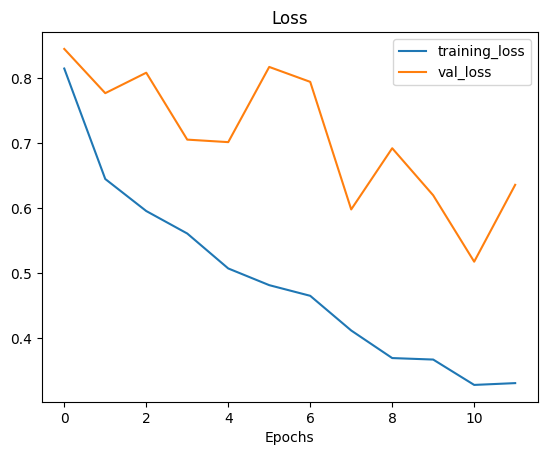

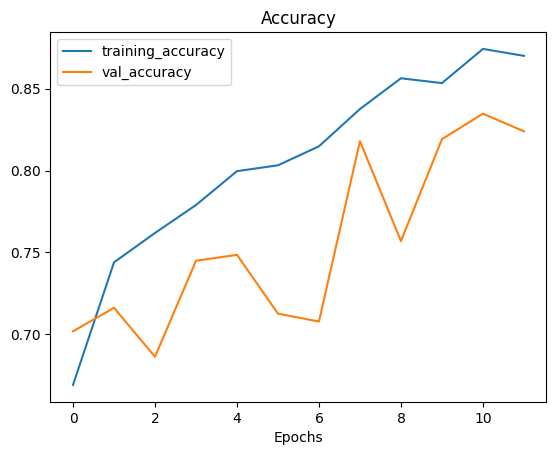

In [156]:
plot_loss_curves(history_baseline)

In [157]:
test_loss, test_acc = baseline_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 360ms/step - accuracy: 0.7287 - loss: 0.6194
Test Accuracy: 0.8329519629478455
Test Loss: 0.4105827510356903


# Fine Tuning InceptionV3

In [208]:
inception_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
inception_model.trainable = False

Using weights = 'imagenet' to load pretrained weights from ImageNet.

In [209]:
x = inception_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(512, activation='relu')(x)  
x = BatchNormalization()(x)        
x = Dropout(0.3)(x)                
x = Dense(256, activation='relu')(x)  
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x) 
x = Dropout(0.1)(x)
predictions = Dense(4, activation='softmax')(x)  

Use BatchNormalization to make the model stabilize. Dropout to make it regularization.

In [210]:
model2 = Model(inputs=inception_model.input, outputs=predictions)

In [212]:
model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_104[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_105[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_106[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_10… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_107[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_108[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,019,684 (87.81 MB)

 Trainable params: 1,215,364 (4.64 MB)

 Non-trainable params: 21,804,320 (83.18 MB)

In [214]:
history_2 = model2.fit(train_data,
                        epochs=15,
                        steps_per_epoch = train_data.samples // train_data.batch_size,
                        validation_data= valid_data,
                        validation_steps = valid_data.samples // valid_data.batch_size,
                        callbacks = [early_stopping, reduce_lr]
                        )

Epoch 1/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.5639 - loss: 0.5443 - val_accuracy: 0.6767 - val_loss: 0.3796 - learning_rate: 1.0000e-04
Epoch 2/15
  1/148 ━━━━━━━━━━━━━━━━━━━━ 1:45 721ms/step - accuracy: 0.8438 - loss: 0.2668

c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


148/148 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 0.8438 - loss: 0.2668 - val_accuracy: 0.6959 - val_loss: 0.3805 - learning_rate: 1.0000e-04
Epoch 3/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 141s 952ms/step - accuracy: 0.8160 - loss: 0.2517 - val_accuracy: 0.7380 - val_loss: 0.3135 - learning_rate: 1.0000e-04
Epoch 4/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - accuracy: 0.7812 - loss: 0.2597 - val_accuracy: 0.7236 - val_loss: 0.3089 - learning_rate: 1.0000e-04
Epoch 5/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 142s 963ms/step - accuracy: 0.8517 - loss: 0.2086 - val_accuracy: 0.7692 - val_loss: 0.2640 - learning_rate: 1.0000e-04
Epoch 6/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.8438 - loss: 0.1812 - val_accuracy: 0.7632 - val_loss: 0.2624 - learning_rate: 1.0000e-04
Epoch 7/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8610 - loss: 0.1858 - val_accuracy: 0.8005 - val_loss: 0.2481 - learning_rate: 1.0000e-04
Epoch 8/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - 

# Evaluation

### AlexNet Evaluation

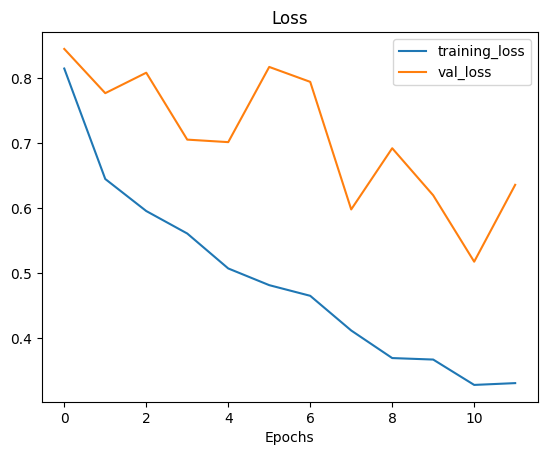

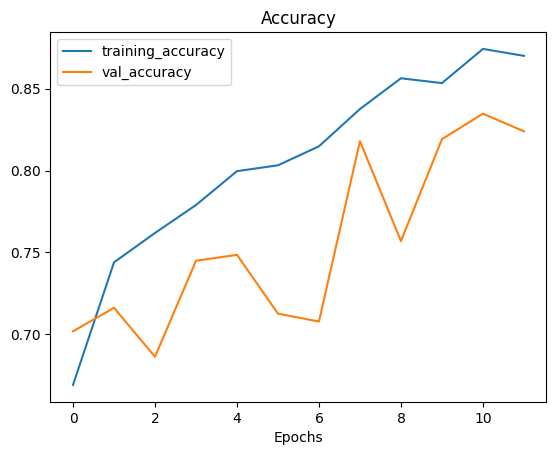

In [218]:
plot_loss_curves(history_baseline)

The training loss consistently decreases from around 0.82 to approximately 0.34, indicating that the model is effectively learning from the training data. However, the validation loss fluctuates and remains generally higher than the training loss, with occasional drops at epochs 7 and 10. This behavior suggests signs of overfitting, where the model performs well on the training set but struggles to generalize to unseen validation data. The widening gap between training and validation loss toward the end further supports this. Despite that, the downward trend in training loss and moments of improved validation performance imply that the model has potential, and with adjustments, its generalization ability could improve.

In [215]:
test_loss, test_acc = baseline_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.7287 - loss: 0.6194
Test Accuracy: 0.8329519629478455
Test Loss: 0.4105827510356903


This model can correctly classify 83% of the times which shows that this model has a really good ability to generalize due to its stable performance in new data. Loss in this model is 0.41 which is pretty low. This shows that the model is certain and not hesitant. 

In [216]:
baseline_predictions = baseline_model.predict(test_data).argmax(axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step


In [217]:
from sklearn.metrics import classification_report

y_pred = baseline_predictions
y_true = test_data.classes

print("\nClassification Report :")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report :
              precision    recall  f1-score   support

      glioma       0.92      0.65      0.76       300
  meningioma       0.69      0.69      0.69       306
     notumor       0.86      0.98      0.91       405
   pituitary       0.87      0.97      0.92       300

    accuracy                           0.83      1311
   macro avg       0.84      0.82      0.82      1311
weighted avg       0.84      0.83      0.83      1311



The classification report indicates that the model performs best in identifying pituitary tumors and non-tumor images, with high precision, recall, and F1-scores (above 0.9), demonstrating strong reliability in those categories. In contrast, glioma detection shows high precision (0.92) but relatively low recall (0.65), meaning the model is confident but misses many true glioma cases. Meningioma proves to be the most challenging class, with both precision and recall at 0.69, suggesting the model struggles to distinguish it, possibly due to visual similarities with other tumor types. Overall, while the model performs well in general, there is room for improvement in recognizing glioma and meningioma cases.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


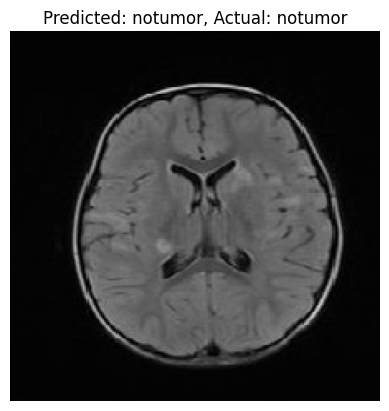

In [219]:
index = 25
img_batch, label_batch = next(test_data)

img = img_batch[index % test_data.batch_size]
label = label_batch[index % test_data.batch_size]

predictions = baseline_model.predict(np.expand_dims(img, axis=0))
predicted_class = np.argmax(predictions, axis=1)[0]  

actual_class = np.argmax(label)
class_labels = list(test_data.class_indices.keys())

plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}, Actual: {class_labels[actual_class]}")
plt.axis('off')
plt.show()


### Evaluation InceptionV3

In [222]:
test_loss, test_acc = model2.evaluate(test_data)
print(f"Test Accuracy : {test_acc}")
print(f"Test Loss: {test_loss}")

y_pred = model2.predict(test_data).argmax(axis=1)
y_true = test_data.classes

print("\nClassification Report :")
print(classification_report(y_true, y_pred, target_names=class_names))

41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 748ms/step - accuracy: 0.8049 - loss: 0.2078
Test Accuracy : 0.8550724387168884
Test Loss: 0.1658962219953537
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 623ms/step

Classification Report :
              precision    recall  f1-score   support

      glioma       0.86      0.81      0.84       300
  meningioma       0.76      0.67      0.71       306
     notumor       0.90      0.96      0.93       405
   pituitary       0.86      0.95      0.90       300

    accuracy                           0.86      1311
   macro avg       0.85      0.85      0.85      1311
weighted avg       0.85      0.86      0.85      1311



The classification report shows that the model performs well overall with an accuracy of 86%, a macro average F1-score of 0.85, and a weighted average F1-score of 0.85. It performs best in classifying "no tumor" cases with a high F1-score of 0.93, followed by "pituitary" (0.90) and "glioma" (0.84). However, the performance on "meningioma" is relatively lower, with an F1-score of 0.71, indicating the model struggles more with this class. To improve results, especially for "meningioma", strategies such as targeted data augmentation, class weighting, or adopting more advanced architectures like DenseNet or EfficientNet could be considered.

### Model Prediction Implementation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


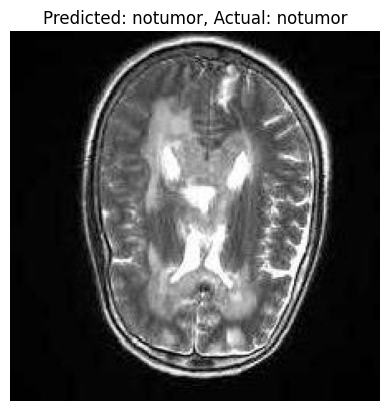

In [223]:
index = 284
img_batch, label_batch = next(test_data)

img = img_batch[index % test_data.batch_size]
label = label_batch[index % test_data.batch_size]

predictions = model2.predict(np.expand_dims(img, axis=0))
predicted_class = np.argmax(predictions, axis=1)[0]  

actual_class = np.argmax(label)
class_labels = list(test_data.class_indices.keys())

plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}, Actual: {class_labels[actual_class]}")
plt.axis('off')
plt.show()

# Overall Evaluation

InceptionV3 Model is overall better than AlexNet model (baseline). It achieves higher overall accuracy (86% vs. 83%) and better macro and weighted F1-scores. It also performs better on three out of four classes, especially on "glioma" and "meningioma". Model 2 does slightly better on "pituitary", but this is not enough to offset the overall drop in performance. Thus, Model 1 is preferred for more consistent and balanced classification across all classes.